Google Drive Authentication
---

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/IIC/

Mounted at /gdrive
/gdrive/My Drive/DrRabiee-Project


Importing/Installing the Necessary Libraries
---

In [ ]:
!pip install shap

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import cv2
from skimage.color import gray2rgb
from tensorflow import keras
import matplotlib.pylab as pl
import shap
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap

Loading the Model
---

In [ ]:
model = load_model('models/mnist.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

Data Preparation
---

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 3)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 3)
x_train = gray2rgb(x_train.reshape(x_train.shape[0],28,28))
x_test = gray2rgb(x_test.reshape(x_test.shape[0],28,28))

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


Classify Custom Images
---

In [ ]:
def prepare_img(filepath):
    img_name = filepath.split('/')[-1]
    im = np.array(Image.open(filepath).convert('L'))
    im = cv2.resize(im, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    im = gray2rgb(im.reshape(28,28))
    return im

In [ ]:
np_img = prepare_img('7.png')

In [ ]:
np_img.shape

(28, 28, 3)

In [ ]:
def classify_img(model, img):
    img = img.reshape((1,img.shape[0],img.shape[1],3))
    img = img.astype("float32") / 255
    pred = model(img)[0]
    class_idx = np.argmax(pred)
    return class_idx

In [ ]:
classify_img(model, np_img)

7

Kernel SHAP
---

Loading an Image

In [ ]:
file = "3.PNG"
img = image.load_img(file, target_size=(28, 28))
img_orig = image.img_to_array(img)

In [ ]:
img_orig.shape

(28, 28, 3)

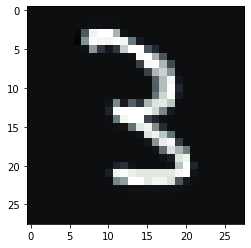

In [ ]:
plt.imshow(img)

Image Segmentation

In [ ]:
num_segments = 50

In [ ]:
segments_slic = slic(img, n_segments=num_segments, compactness=30, sigma=3)

Masking

In [ ]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(mask_image(z, segments_slic, img_orig, 255))

Making the Explainer Object and Training it

In [ ]:
explainer = shap.KernelExplainer(f, np.zeros((1,num_segments)))
shap_values = explainer.shap_values(np.ones((1,num_segments)), nsamples=1000)

Getting the Top Predictions

In [ ]:
preds = model.predict(np.expand_dims(img_orig.copy(), axis=0))
top_preds = np.argsort(-preds)

In [ ]:
top_preds

array([[3, 0, 1, 2, 4, 5, 6, 7, 8, 9]])

In [ ]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [ ]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

In [ ]:
feature_names = {'0':['n1','0'], '1':['n2','1'], '2':['n3','2'], '3':['n4','3'], '4':['n5','4'], '5':['n6','5'], '6':['n7','6'], '7':['n8','7'], '8':['n9','8'], '9':['n10','9']}

Explaning the Predictions

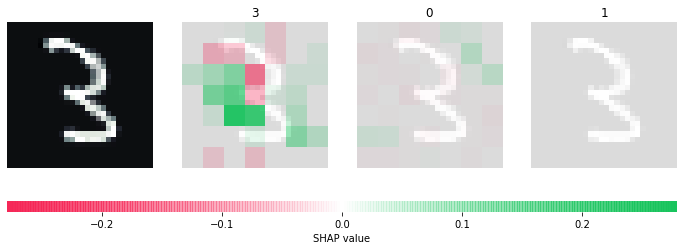

In [ ]:
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
pl.show()